In [1]:
# Title:

In [1]:
# packages
import datetime as dt

from quantified_strategies import strategy_utils

import constants
import utils

2024-03-05 19:20:16.931 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [49]:
# parameters

# Trading Parameters
ASSETS = ["VUSA.LSE", "CNX1.LSE", utils.CASH]
FILE = "strategy_returns_us_european_etfs.csv"
# ASSETS = ["SPY.US", "QQQ.US", utils.CASH]
# ASSETS = ["SPY.US", utils.CASH]
# ASSETS = ["QQQ.US", utils.CASH]
# FILE = "strategy_returns_us_american_etfs.csv"
# ASSETS = ["SPY.US", "QQQ.US", "XLC.US", "XLE.US", "XLF.US", "XLI.US", "XLK.US", "XLP.US", "XLRE.US", "XLU.US", "XLY.US", "XLV.US", utils.CASH]
# FILE = "strategy_returns_us_sector_american_etfs.csv"

START = dt.date(2012, 1, 1)
END = dt.date.today()

# Fetch costs involved in trading assets
LONG_OVERNIGHT_COSTS = [constants.LONG_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]
SHORT_OVERNIGHT_COSTS = [constants.SHORT_OVERNIGHT_COSTS_DICT.get(asset, 0.0) for asset in ASSETS]

In [50]:
# Get Data
X, y = utils.get_raw_data(assets=ASSETS, file=FILE, start=START, end=END)
X.loc[:, X.columns.get_level_values(1) == "september_bear"] *= -1

{}
remove api from here
{}
remove api from here


C:\Users\tomw1\PycharmProjects\quantified_strategies\quantified_strategies\scripts\strategy_activation_asset_allocator\utils.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_data = price_data.pct_change()


In [142]:
import pandas as pd
import typing as t

def run(X_df: pd.DataFrame, y_df: pd.DataFrame, **kwargs) -> t.Dict[str, pd.DataFrame]:
    
    assets = y_df.columns.tolist()
    
    long_costs_df = pd.Series(LONG_OVERNIGHT_COSTS, index=assets)
    short_costs_df = pd.Series(SHORT_OVERNIGHT_COSTS, index=assets)

    # Allocation
    ## Strategy Activation
    alloc = X_df.T.groupby(level=2).sum().T
    alloc = alloc.div(alloc.abs().sum(axis=1), axis=0).fillna(0.0)
    alloc = alloc.reindex(columns=y_df.columns, fill_value=0.0)
    alloc[utils.CASH] = 1 - alloc.sum(axis=1)
    
    ## HODL
    hodl_alloc = pd.DataFrame(1 / (len(assets) - 1), index=alloc.index, columns=assets)
    hodl_alloc[utils.CASH] = 0.0

    # Get Strategy returns
    strat_ret = (y_df * alloc).sum(axis=1) #- (alloc.clip(lower=0.0).dot(long_costs_df) + alloc.clip(upper=0.0).abs().dot(short_costs_df))
    hodl_ret = (y_df * hodl_alloc).sum(axis=1) #- (hodl_alloc.clip(lower=0.0).dot(long_costs_df) + hodl_alloc.clip(upper=0.0).abs().dot(short_costs_df))

    def format_alloc(df: pd.DataFrame) -> pd.DataFrame:
        return df.rename(columns={col: f"w_{col}" for col in df.columns})
    
    df_strat = pd.concat([y_df, format_alloc(df=alloc), strat_ret.to_frame(name="ret")], axis=1)
    df_hodl = pd.concat([y_df, format_alloc(df=hodl_alloc), hodl_ret.to_frame(name="ret")], axis=1)

    return {"strat": df_strat, "hodl": df_hodl}


In [143]:
all_strat_dicts = run(X_df=X, y_df=y)

In [144]:
strat_df = all_strat_dicts["strat"].copy()
hodl_df = all_strat_dicts["hodl"].copy()

<Axes: >

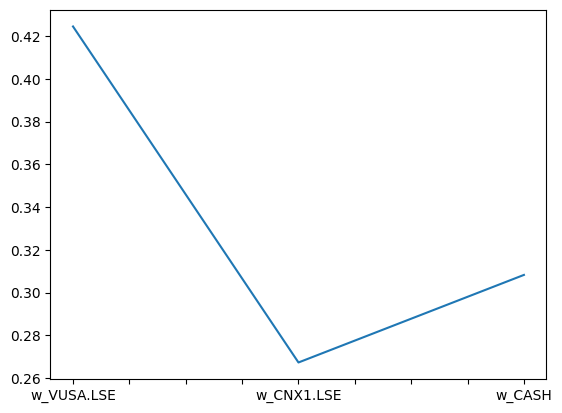

In [145]:
strat_df[[f"w_{asset}" for asset in ASSETS]].mean().plot()

In [161]:
FROM_DATE = dt.date(2022, 1, 1)
TO_DATE = dt.date(2023, 12, 31)
# FROM_DATE = dt.date(2024, 1, 1)
# TO_DATE = dt.date(2024, 12, 31)

In [162]:
hodl_df_ = hodl_df.loc[(hodl_df.index.date >= FROM_DATE) & (hodl_df.index.date <= TO_DATE)]
strat_df_ = strat_df.loc[(strat_df.index.date >= FROM_DATE) & (strat_df.index.date <= TO_DATE)]

hodl_ret = strategy_utils.get_cumulative_return(returns=hodl_df_["ret"], total=False)
strat_ret = strategy_utils.get_cumulative_return(returns=strat_df_["ret"], total=False)

hodl_pos = hodl_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)
strat_pos = strat_df_[[f"w_{asset}" for asset in ASSETS if asset != utils.CASH]].sum(axis=1)

In [163]:
import matplotlib.pyplot as plt

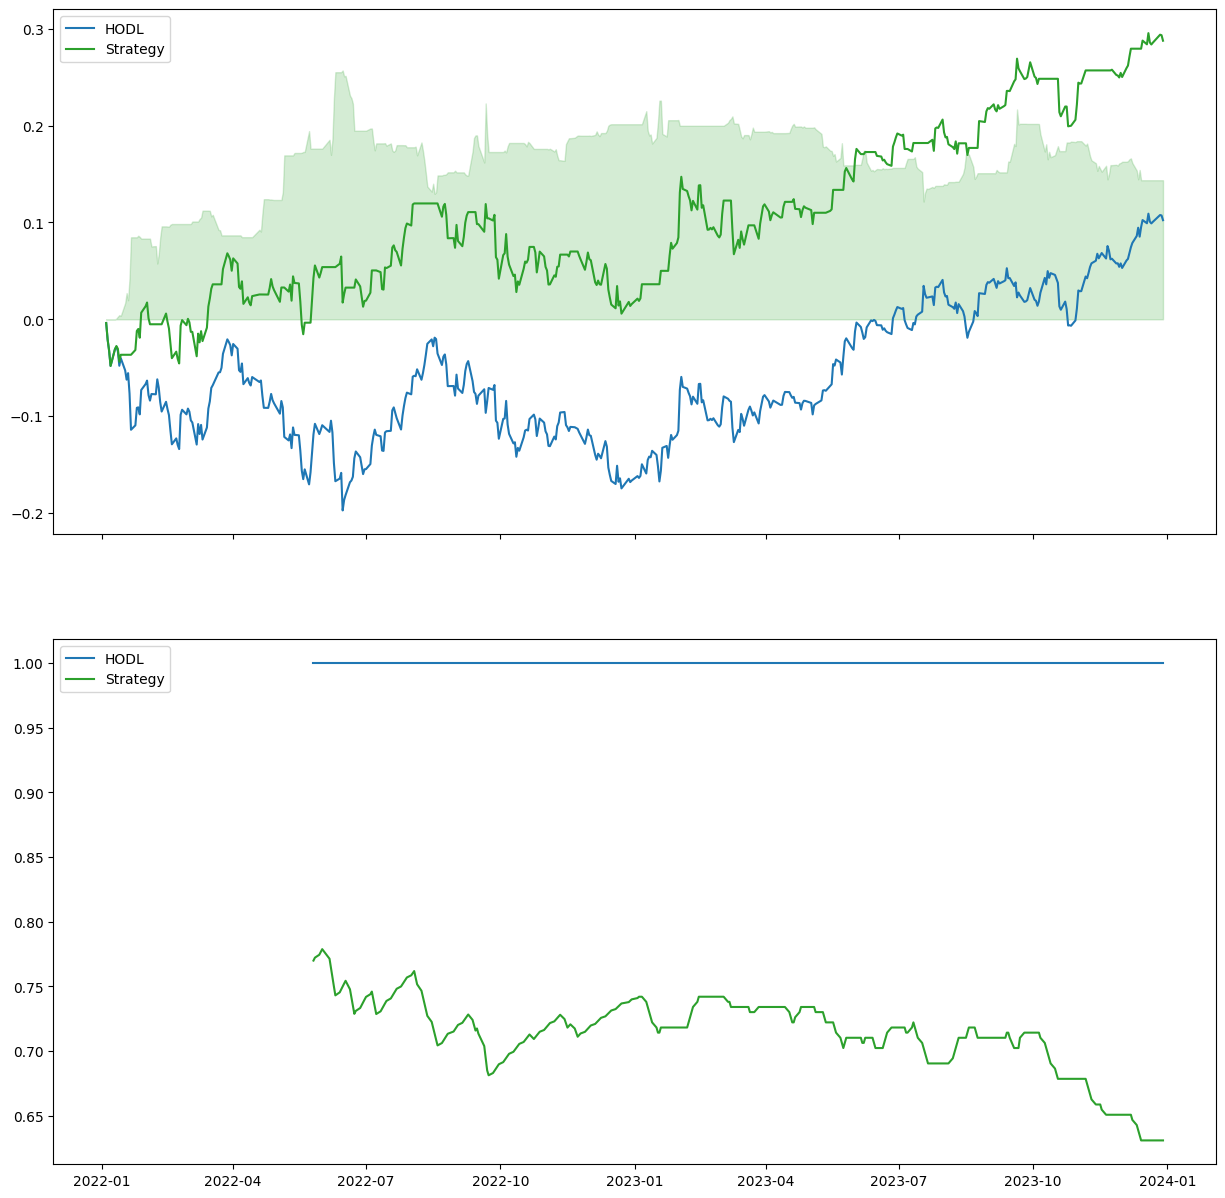

In [164]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(15, 15), sharex="col", nrows=2)

ax[0].plot(hodl_ret, label="HODL", color=colors[0])
ax[0].plot(strat_ret, label="Strategy", color=colors[2])
ax[0].fill_between(
    hodl_ret.index, 0, 
    strategy_utils.get_cumulative_return(returns=strat_df_["ret"]-hodl_df_["ret"], total=False), 
    color=colors[2],
    alpha=0.2,
)
# for i, asset in enumerate(ASSETS):
#     ax[0].plot(strategy_utils.get_cumulative_return(returns=strat_df_[asset], total=False), label=asset, color=colors[3+i])

ax[0].legend()

# Activity
ax[1].plot(hodl_pos.rolling(window=252, min_periods=100).mean(), label="HODL", color=colors[0])
ax[1].plot(strat_pos.rolling(window=252, min_periods=100).mean(), label="Strategy", color=colors[2])
ax[1].legend(loc="upper left")

plt.show()


In [165]:
df = pd.concat([strat_df_["ret"], strat_pos.diff().fillna(1.0).clip(lower=0.0).cumsum().to_frame(name="trade_number")], axis=1)
trade_ret = df.groupby("trade_number")["ret"].apply(lambda x: (1 + x).prod() - 1)
trade_ret.index = trade_ret.index.map(df.reset_index().groupby("trade_number")["Date"].first().to_dict())
trade_ret

trade_number
2022-01-04   -0.036635
2022-01-24    0.032719
2022-02-14   -0.007890
2022-03-07    0.049733
2022-03-25   -0.010101
2022-04-25    0.007003
2022-05-09   -0.035164
2022-05-25    0.057599
2022-06-13   -0.020102
2022-06-24    0.017186
2022-07-11    0.065870
2022-08-22   -0.007993
2022-09-15   -0.005788
2022-09-23    0.000000
2022-09-26   -0.026738
2022-10-25   -0.007403
2022-11-17    0.003007
2022-11-24   -0.031596
2023-01-19    0.013355
2023-01-25    0.069142
2023-03-09   -0.022806
2023-03-27    0.022116
2023-04-20   -0.010047
2023-05-15    0.021298
2023-05-25    0.032579
2023-06-08    0.001832
2023-06-16    0.002697
2023-07-10    0.005237
2023-07-24   -0.000254
2023-08-17   -0.004044
2023-08-25    0.058384
2023-09-19    0.010851
2023-09-22   -0.008597
2023-10-19   -0.022956
2023-10-25    0.030585
2023-11-24    0.017850
2023-12-15    0.006437
Name: ret, dtype: float64

In [166]:
desc = pd.concat([
    strategy_utils.describe(returns=strat_df_["ret"], pos=strat_pos, daily=True).to_frame(name="strategy"),
    strategy_utils.describe(returns=trade_ret, daily=False).to_frame(name="strategy/trade"),
    strategy_utils.describe(returns=hodl_df_["ret"], pos=hodl_pos, daily=True).to_frame(name="hodl")
], axis=1)
desc

,strategy,strategy/trade,hodl
Asset,Undefined,Undefined,Undefined
Start,2022-01-04,2022-01-04,2022-01-04
End,2023-12-29,2023-12-15,2023-12-29
Mean Return,0.07690%,0.72262%,0.02609%
Total Return,28.55%,28.78%,10.24%
Median Return,0.02359%,0.26969%,0.01373%
1st Quartile,-0.53474%,-0.93219%,-0.61690%
3rd Quartile,0.74612%,2.17069%,0.72179%
Std Dev Return,1.14325%,2.77366%,1.15251%
CAGR,7.038 bps,68.585 bps,1.946 bps
